In [1]:
#TO-DO Add a non-dog category: https://www.reddit.com/r/computervision/comments/xhzasm/question_about_image_classification_with_1_class/
#TO-DO confusion matrix, accuracy, precision, recall

# Get Dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

train_dir = './Dataset/training_set'
test_dir = './Dataset/test_set'

img_height=256
img_width=256

c:\Users\duerh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [23]:
train_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

val_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=32
)

Found 7031 files belonging to 2 classes.
Using 5625 files for training.
Found 7031 files belonging to 2 classes.
Using 1406 files for validation.
Found 1085 files belonging to 2 classes.


In [4]:
import os
from PIL import Image #pillow library

train_dogs = train_dir + "/dogs/"
train_notDogs = train_dir + "/not-dogs/"
test_dogs = test_dir + "/dogs/"
test_notDogs = test_dir + "/not-dogs/"

direcs = [train_dogs, train_notDogs, test_dogs, test_notDogs]
for direc in direcs:
    filenames = os.listdir(direc)
    remove = False

    print("Validating files formats...")
    for file in filenames:
        file_path = os.path.join(direc, file)
        # img = tf.keras.utils.load_img(direc + file)
        with Image.open(file_path) as img:
            if img.format != "jpg" and img.format != "JPEG":
                print("Not jpg. Removing...", img.format, file)
                remove = True
            else:
                try:
                    img.convert("RGB")
                    img.save(file_path)
                except Exception as e:
                    print(f"Removing corrupted image: {file_path}")
        if remove == True:
            os.remove(file_path)

Validating files formats...
Validating files formats...
Validating files formats...
Validating files formats...
Not jpg. Removing... BMP 10073.jpg
Not jpg. Removing... GIF 10125.jpg
Not jpg. Removing... PSD 10404.jpg
Not jpg. Removing... GIF 10501.jpg
Not jpg. Removing... GIF 10820.jpg
Not jpg. Removing... BMP 10874.jpg
Not jpg. Removing... BMP 11083.jpg
Not jpg. Removing... BMP 11086.jpg
Not jpg. Removing... BMP 11095.jpg
Not jpg. Removing... GIF 11210.jpg
Not jpg. Removing... BMP 11397.jpg
Not jpg. Removing... GIF 11565.jpg
Not jpg. Removing... BMP 11729.jpg
Not jpg. Removing... BMP 11864.jpg
Not jpg. Removing... GIF 11874.jpg
Not jpg. Removing... GIF 11935.jpg
Not jpg. Removing... BMP 12080.jpg
Not jpg. Removing... BMP 12235.jpg
Not jpg. Removing... BMP 12269.jpg
Not jpg. Removing... BMP 6376.jpg
Not jpg. Removing... BMP 6435.jpg
Not jpg. Removing... BMP 6486.jpg
Not jpg. Removing... BMP 6491.jpg
Not jpg. Removing... BMP 6768.jpg
Not jpg. Removing... BMP 6900.jpg
Not jpg. Removing..

In [5]:
print(test_set.class_names)

['dogs', 'not-dogs']


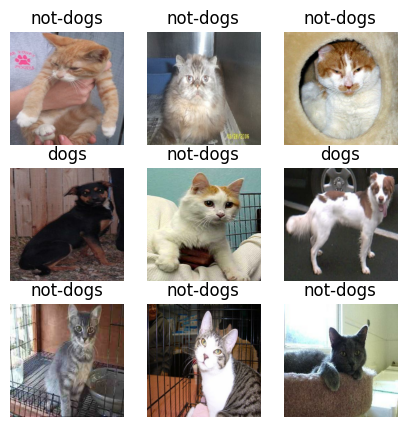

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_set.take(1):
    for i in range(9):
        plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_set.class_names[labels[i]])
        plt.axis('off')

In [7]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  break

(32, 256, 256, 3)


# Standardise

In [8]:
normalization_layer = layers.Rescaling(1./255)
train_set = train_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_set))
first_image = image_batch[0]

# Pixel values are now in [0,1]
print(np.min(first_image), np.max(first_image))

0.0013403799 0.9997676


# Create Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()
#Adding Convolutional Layer and Pooling Layer
#The first layer needs to contain an input hence this conv2D containes "input_shape"
#Conv2D has 16 filters, 3x3 filter size, moves 1 pixel
#Inputs are size of image and 3 channels deep
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(img_height,img_width,3)))
#Condenses a 2x2 (which is default size) into 1x1 taking the maximum value
#MaxPooling2D?? shoes the default values of that method
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#The conv2D added make up the 3 channels of the input
#Flattening condenses the channels into just 1 layer
model.add(Flatten())

#Dense layers are fully connected layers
#256 neurons
model.add(Dense(256, activation='relu'))
#Another dense layer with only 1 neuron 
#Will output 0 or 1 because of the sigmoid function
model.add(Dense(1, activation='sigmoid'))

c:\Users\duerh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile Model

In [10]:
model.compile(optimizer='adam', #Algorithm used to minimise a loss function or maximise learning efficiency like change weights and learning rate to reduce loss
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,769,697 (56.34 MB)

 Trainable params: 14,769,697 (56.34 MB)

 Non-trainable params: 0 (0.00 B)

# Run Model

In [12]:
epochs = 5
history = model.fit(train_set,
                     epochs=epochs,
                     validation_data=val_set)

Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.9019 - loss: 0.3600 - val_accuracy: 0.9061 - val_loss: 29.4256
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.9026 - loss: 0.3043 - val_accuracy: 0.7475 - val_loss: 20.7869
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 36s 204ms/step - accuracy: 0.9074 - loss: 0.2684 - val_accuracy: 0.7176 - val_loss: 46.4672
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.9186 - loss: 0.2278 - val_accuracy: 0.7553 - val_loss: 30.7162
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.9372 - loss: 0.1715 - val_accuracy: 0.8314 - val_loss: 67.5054


# Evaluation

In [13]:
import matplotlib.pyplot as plot

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Acc')

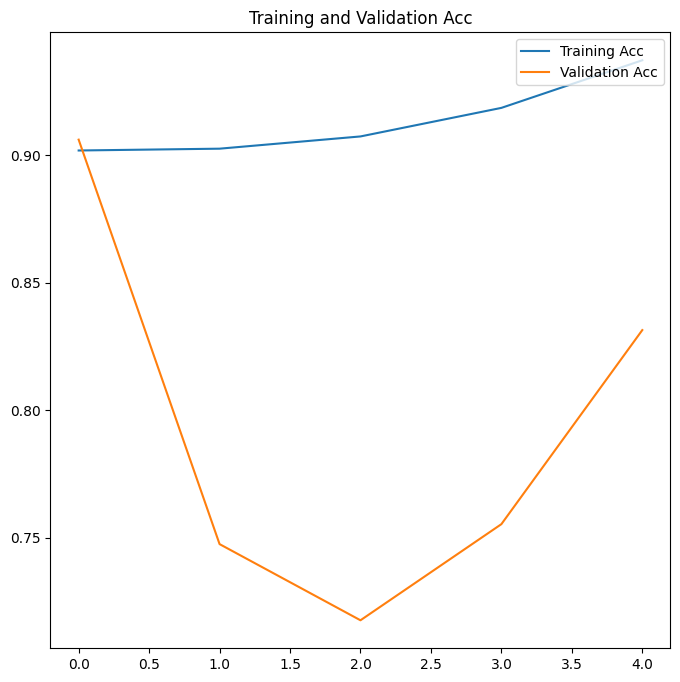

In [15]:
plot.figure(figsize=(8,8))
plot.plot(range(epochs), acc, label='Training Acc')
plot.plot(range(epochs), val_acc, label='Validation Acc')
plot.legend(loc='upper right')
plot.title('Training and Validation Acc')

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [29]:
import numpy as np

y_true = np.concatenate([y for x, y in test_set], axis=0)

predictions = model.predict(test_set)
y_pred = (predictions > 0.5).astype("int32").flatten()
print(predictions)

test_labels= test_set.class_names

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


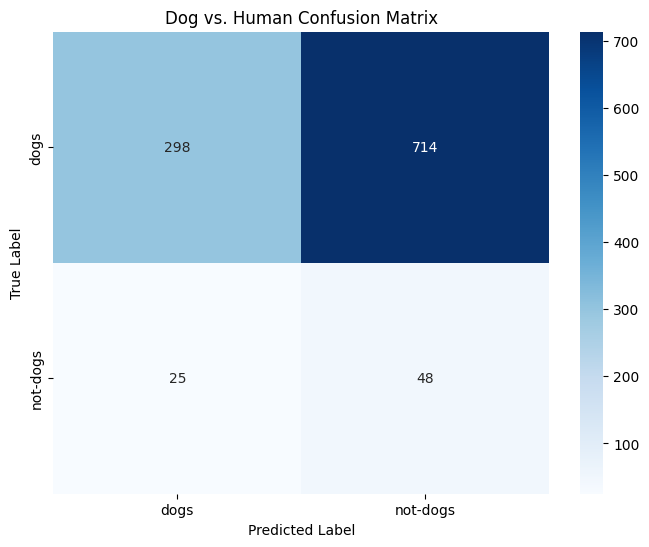

In [33]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_set.class_names, 
            yticklabels=test_set.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Dog vs. Human Confusion Matrix')
plt.show()